In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


2023-04-24 17:09:56.407710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 17:09:56.475065: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
IMAGE_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/d2/Dataset/MainImages"
MASK_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/d2/Dataset/Cropped_cup"
BATCH_SIZE = 4

In [3]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def create_unet():
    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32) # 64
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64) # 128
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128) # 256
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256) # 512
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 256) # 1024

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256) # 512
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128) # 256
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64) # 128
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32)
    # outputs
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [4]:
# load data
assert len(os.listdir(IMAGE_DIR)) == len(os.listdir(MASK_DIR)), "Different number of images and masks"
X, Y, file_names = [], [], []
for image_name in sorted(os.listdir(IMAGE_DIR)):
    mask_name = image_name
    

    image = cv2.imread(os.path.join(IMAGE_DIR, image_name))
    image = cv2.resize(image, (256, 256))
    

    mask = cv2.imread(os.path.join(MASK_DIR, mask_name))
    mask = cv2.resize(mask, (256, 256))


    X.append(image)
    Y.append(mask)
    file_names.append(image_name)


In [5]:
def dice_coef(y_true, y_pred): # accuracy function 
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
  
def dice_loss(y_true,y_pred): # loss function 
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -tf.math.log(dice_coef(y_true, y_pred))



def iou(y_true, y_pred, threshold=0.5):                                                             
    y_true = tf.reshape(y_true, [-1])                                                               
    y_true = tf.cast(y_true, tf.float32)                                                            
    y_pred = tf.cast(y_pred > threshold, tf.float32)                                                
                                                                                                    
    y_pred = tf.reshape(y_pred, [-1])                                                               
                                                                                                    
                                                                                                    
    intersection = tf.reduce_sum(y_true*y_pred)                                                     
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))                                 
                                                                                                    
    return intersection/union 

In [6]:
def augmentation_fn(image, mask, training=True):
    """
    Augmentation for training set only. random cropy 50% of the time, random flip 50% of the time
    """
    # change brightness

    image = image.copy()
    mask = mask.copy()
    if training:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_hue(image, 0.1)
    
        seed = np.random.randint(0, 1000, (2, ))
        if np.random.rand() < 0.5:
            random_size = np.random.randint(210, 256) # this is because the size of the image is 256 
        
            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=seed)
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=seed)

        if np.random.rand() < 0.5:
            image = tf.image.stateless_random_flip_up_down(image, seed)
            mask = tf.image.stateless_random_flip_up_down(mask, seed)


    image = tf.image.resize(image, (128, 128))/122.5 - 1.0
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1]
    
    return image, mask



In [7]:
# Split train and test
mask = list(range(len(X)))
np.random.seed(0)
np.random.shuffle(mask)
n_train = int(0.8*len(mask))
X_train = [X[i] for i in mask[:n_train]]
Y_train = [Y[i] for i in mask[:n_train]]
name_train = [file_names[i] for i in mask[:n_train]]

X_test = [X[i] for i in mask[n_train:]]
Y_test = [Y[i] for i in mask[n_train:]]
name_test = [file_names[i] for i in mask[n_train:]]

def data_generator(X, Y, batch_size=BATCH_SIZE, training=True):
    n_data = len(X)

    i = 0
    while True:
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            X = [X[j] for j in mask]
            Y = [Y[j] for j in mask]
        
        mini_X = X[i: i + batch_size] 
        mini_Y = Y[i: i + batch_size]

        
        processed_data = [augmentation_fn(x, y, training) for x, y in zip(mini_X, mini_Y)]
        mini_X = [item[0] for item in processed_data]
        mini_Y = [item[1] for item in processed_data]


        mini_X = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_X], axis=0)
        mini_Y = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_Y], axis=0)

        i += batch_size
        yield mini_X, mini_Y



In [8]:
model = create_unet()

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=log_dice_loss,
    metrics=[dice_coef, iou]
)

train_generator = data_generator(X_train, Y_train, training=True)
validation_generator = data_generator(X_test, Y_test, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_test)//BATCH_SIZE,
    callbacks=[early_stopping]
)

2023-04-24 17:10:01.580656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-04-24 17:10:01.582412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20509 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:3e:00.0, compute capability: 8.6
2023-04-24 17:10:01.583447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 15314 MB memory:  -> device: 2, name: GeForce RTX 3090, pci bus id: 0000:89:00.0, compute capability: 8.6
2023-04-24 17:10:01.584858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22288 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:b2:00.0, 

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 64  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
          

2023-04-24 17:10:04.182685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-24 17:10:05.626842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-24 17:10:07.580917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 10s 64ms/step - loss: 2.6500 - dice_coef: 0.0796 - iou: 0.0712 - val_loss: 2.1925 - val_dice_coef: 0.1175 - val_iou: 0.0579
Epoch 2/300
14/14 [==============================] - 1s 42ms/step - loss: 1.4815 - dice_coef: 0.2637 - iou: 0.2268 - val_loss: 1.1806 - val_dice_coef: 0.3138 - val_iou: 0.2141
Epoch 3/300
14/14 [==============================] - 1s 40ms/step - loss: 0.9569 - dice_coef: 0.4033 - iou: 0.2981 - val_loss: 1.8748 - val_dice_coef: 0.1928 - val_iou: 0.1135
Epoch 4/300
14/14 [==============================] - 1s 39ms/step - loss: 1.0350 - dice_coef: 0.4131 - iou: 0.2984 - val_loss: 3.5161 - val_dice_coef: 0.2864 - val_iou: 0.1963
Epoch 5/300
14/14 [==============================] - 1s 40ms/step - loss: 1.1676 - dice_coef: 0.3387 - iou: 0.2208 - val_loss: 1.1312 - val_dice_coef: 0.3388 - val_iou: 0.2212
Epoch 6/300
14/14 [==============================] - 1s 39ms/step - loss: 0.9797 - dice_coef: 0.4226 - iou: 0.2909 - val_loss: 0.69

14/14 [==============================] - 1s 39ms/step - loss: 0.3970 - dice_coef: 0.6833 - iou: 0.5330 - val_loss: 0.4842 - val_dice_coef: 0.6308 - val_iou: 0.4741
Epoch 48/300
14/14 [==============================] - 1s 40ms/step - loss: 0.3508 - dice_coef: 0.7072 - iou: 0.5515 - val_loss: 0.4720 - val_dice_coef: 0.6303 - val_iou: 0.4672
Epoch 49/300
14/14 [==============================] - 1s 40ms/step - loss: 0.4298 - dice_coef: 0.6629 - iou: 0.5052 - val_loss: 0.4962 - val_dice_coef: 0.6131 - val_iou: 0.4484
Epoch 50/300
14/14 [==============================] - 1s 38ms/step - loss: 0.3431 - dice_coef: 0.7119 - iou: 0.5566 - val_loss: 0.4632 - val_dice_coef: 0.6327 - val_iou: 0.4690
Epoch 51/300
14/14 [==============================] - 1s 39ms/step - loss: 0.3876 - dice_coef: 0.6840 - iou: 0.5267 - val_loss: 0.5259 - val_dice_coef: 0.6039 - val_iou: 0.4454
Epoch 52/300
14/14 [==============================] - 0s 37ms/step - loss: 0.3431 - dice_coef: 0.7144 - iou: 0.5633 - val_loss: 

14/14 [==============================] - 1s 39ms/step - loss: 0.3219 - dice_coef: 0.7289 - iou: 0.5791 - val_loss: 0.5233 - val_dice_coef: 0.5936 - val_iou: 0.4234
Epoch 94/300
14/14 [==============================] - 1s 40ms/step - loss: 0.2977 - dice_coef: 0.7451 - iou: 0.5979 - val_loss: 0.5492 - val_dice_coef: 0.5821 - val_iou: 0.4155
Epoch 95/300
14/14 [==============================] - 1s 39ms/step - loss: 0.3254 - dice_coef: 0.7286 - iou: 0.5824 - val_loss: 0.5241 - val_dice_coef: 0.5926 - val_iou: 0.4216
Epoch 96/300
14/14 [==============================] - 1s 39ms/step - loss: 0.3188 - dice_coef: 0.7312 - iou: 0.5826 - val_loss: 0.6363 - val_dice_coef: 0.5338 - val_iou: 0.3693
Epoch 97/300
14/14 [==============================] - 1s 39ms/step - loss: 0.3473 - dice_coef: 0.7126 - iou: 0.5604 - val_loss: 0.6093 - val_dice_coef: 0.5471 - val_iou: 0.3798
Epoch 98/300
14/14 [==============================] - 0s 36ms/step - loss: 0.2667 - dice_coef: 0.7677 - iou: 0.6271 - val_loss: 

14/14 [==============================] - 1s 38ms/step - loss: 0.2771 - dice_coef: 0.7627 - iou: 0.6232 - val_loss: 0.4917 - val_dice_coef: 0.6129 - val_iou: 0.4449
Epoch 140/300
14/14 [==============================] - 1s 41ms/step - loss: 0.2737 - dice_coef: 0.7639 - iou: 0.6231 - val_loss: 0.5059 - val_dice_coef: 0.6114 - val_iou: 0.4462
Epoch 141/300
14/14 [==============================] - 1s 40ms/step - loss: 0.2777 - dice_coef: 0.7634 - iou: 0.6258 - val_loss: 0.5602 - val_dice_coef: 0.5736 - val_iou: 0.4030
Epoch 142/300
14/14 [==============================] - 1s 39ms/step - loss: 0.2500 - dice_coef: 0.7805 - iou: 0.6441 - val_loss: 0.4592 - val_dice_coef: 0.6320 - val_iou: 0.4653
Epoch 143/300
14/14 [==============================] - 0s 37ms/step - loss: 0.2386 - dice_coef: 0.7899 - iou: 0.6572 - val_loss: 0.5634 - val_dice_coef: 0.5723 - val_iou: 0.4042
Epoch 144/300
14/14 [==============================] - 1s 40ms/step - loss: 0.2783 - dice_coef: 0.7598 - iou: 0.6183 - val_l

14/14 [==============================] - 1s 39ms/step - loss: 0.2188 - dice_coef: 0.8057 - iou: 0.6786 - val_loss: 0.6148 - val_dice_coef: 0.5419 - val_iou: 0.3734
Epoch 186/300
14/14 [==============================] - 0s 37ms/step - loss: 0.2106 - dice_coef: 0.8122 - iou: 0.6885 - val_loss: 0.5714 - val_dice_coef: 0.5705 - val_iou: 0.4049
Epoch 187/300
14/14 [==============================] - 0s 35ms/step - loss: 0.2225 - dice_coef: 0.8049 - iou: 0.6810 - val_loss: 0.4816 - val_dice_coef: 0.6214 - val_iou: 0.4539
Epoch 188/300
14/14 [==============================] - 0s 37ms/step - loss: 0.2256 - dice_coef: 0.7996 - iou: 0.6694 - val_loss: 0.6553 - val_dice_coef: 0.5208 - val_iou: 0.3545
Epoch 189/300
14/14 [==============================] - 1s 39ms/step - loss: 0.2422 - dice_coef: 0.7880 - iou: 0.6561 - val_loss: 0.5158 - val_dice_coef: 0.5996 - val_iou: 0.4314
Epoch 190/300
14/14 [==============================] - 0s 37ms/step - loss: 0.2245 - dice_coef: 0.8009 - iou: 0.6724 - val_l

In [9]:
best_epoch = np.argmin(history.history["val_loss"])
print("Best Validation Loss: ", history.history["val_loss"][best_epoch])
print("Best Dice Coffecient (F1): ", history.history["val_dice_coef"][best_epoch])
print("Best IoU (Jaccard): ", history.history["val_iou"][best_epoch])


Best Validation Loss:  0.38268113136291504
Best Dice Coffecient (F1):  0.6849384307861328
Best IoU (Jaccard):  0.5250433683395386


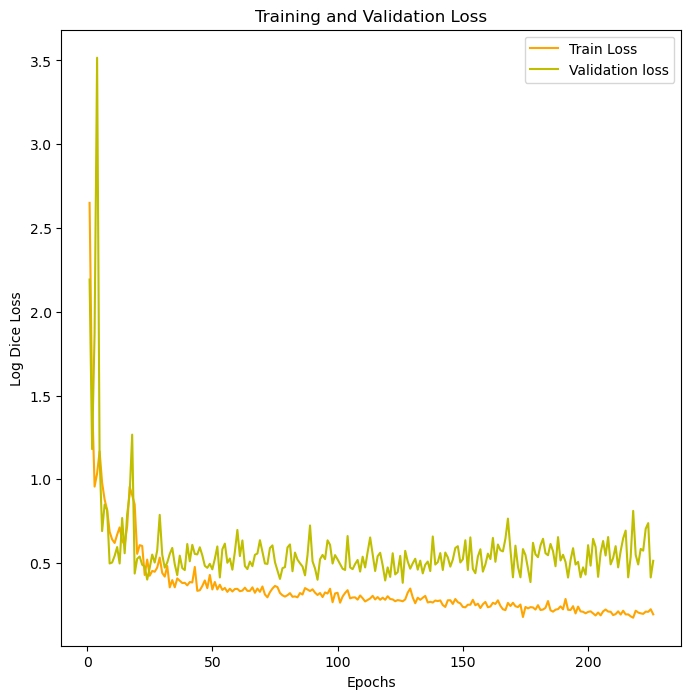

In [11]:
t_loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['dice_coef']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.plot(epochs, t_loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Dice Loss')
# plt.grid()
plt.legend()


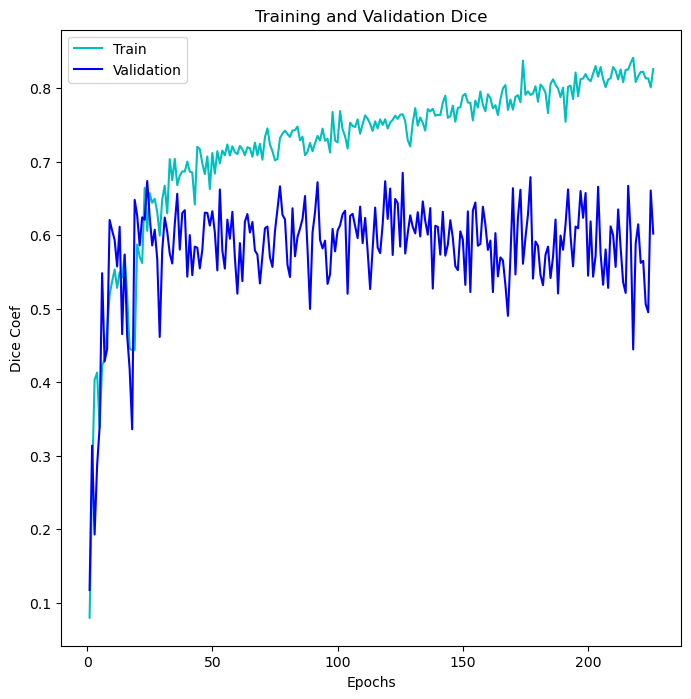

In [12]:
loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, acc, 'c', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
# plt.grid()
plt.legend()

In [11]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

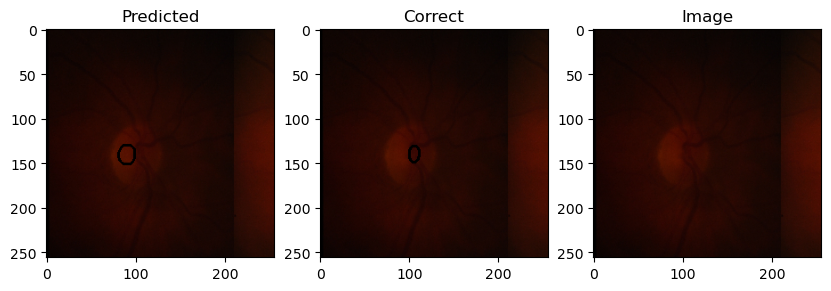

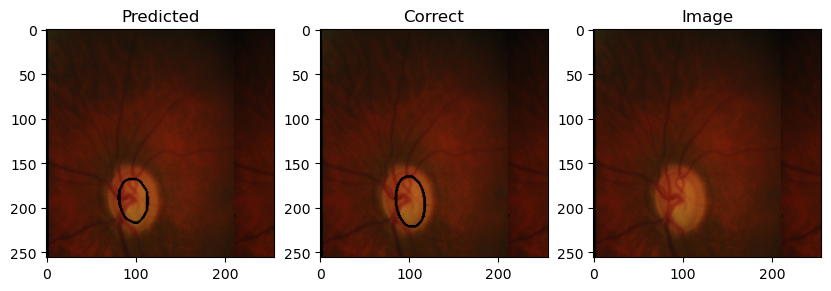

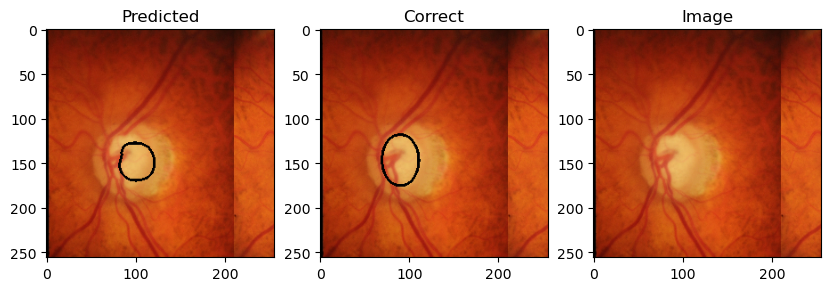

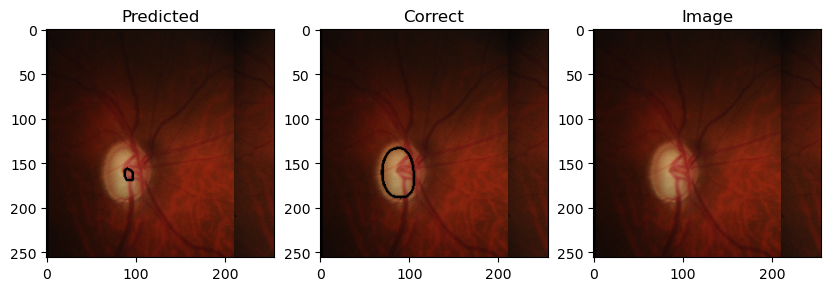

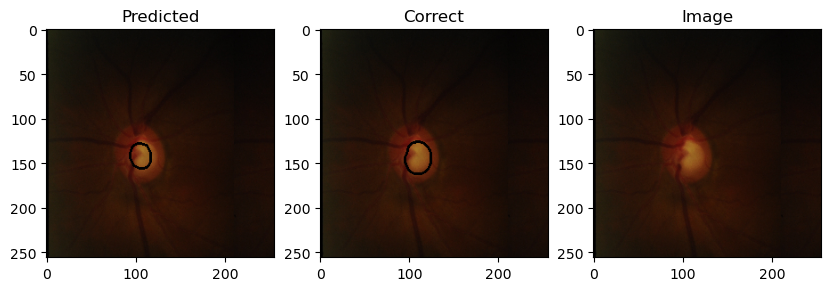

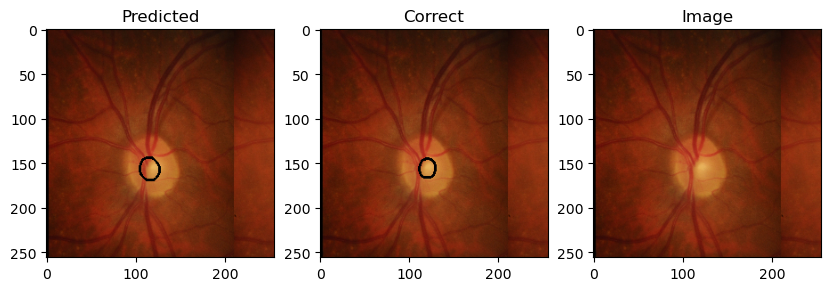

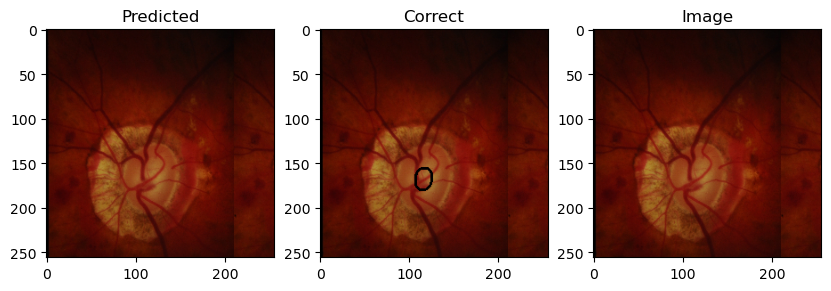

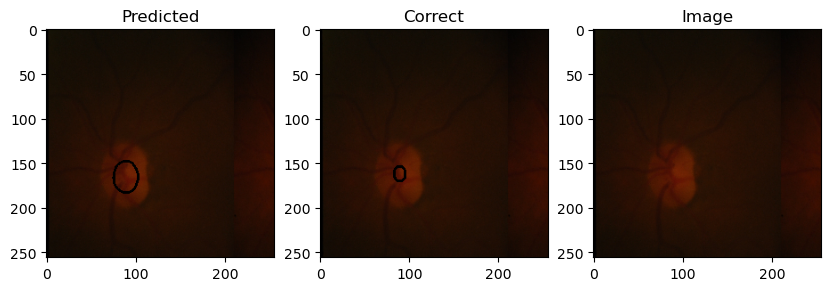

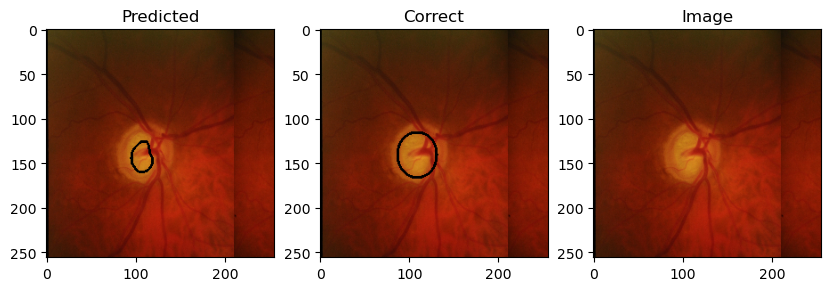

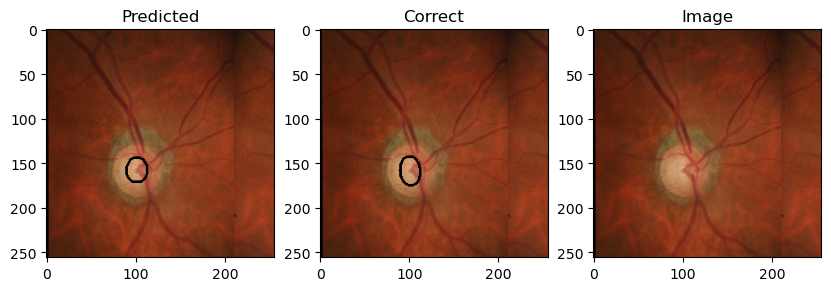

In [12]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

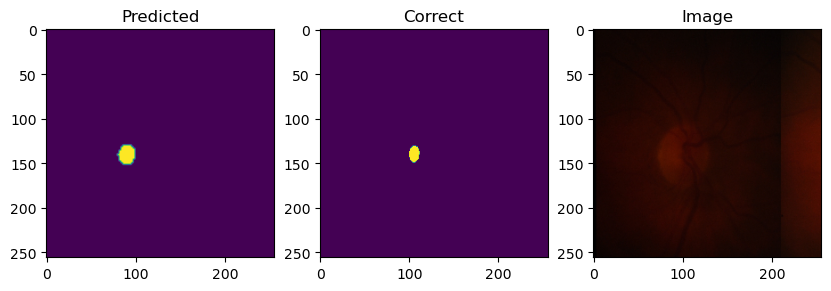

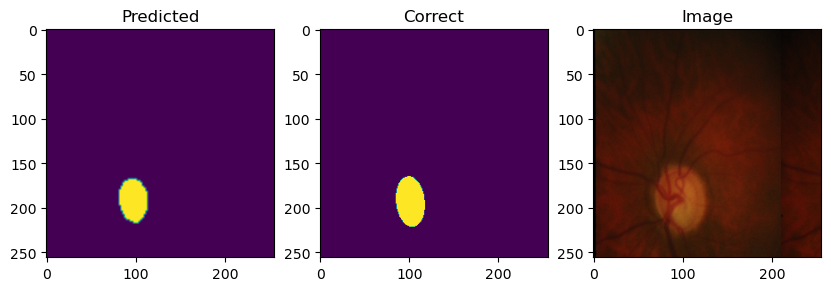

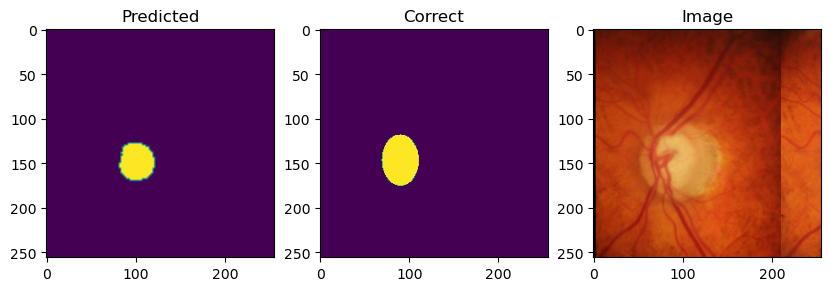

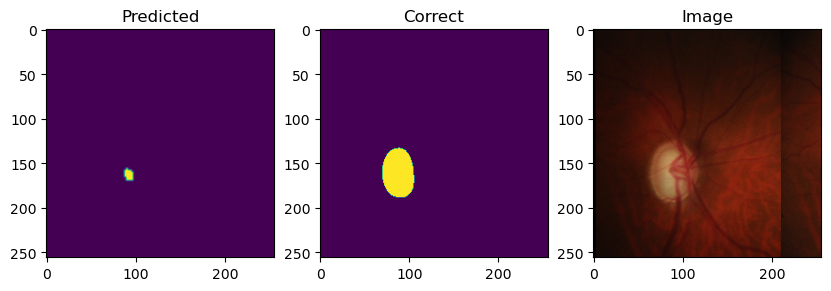

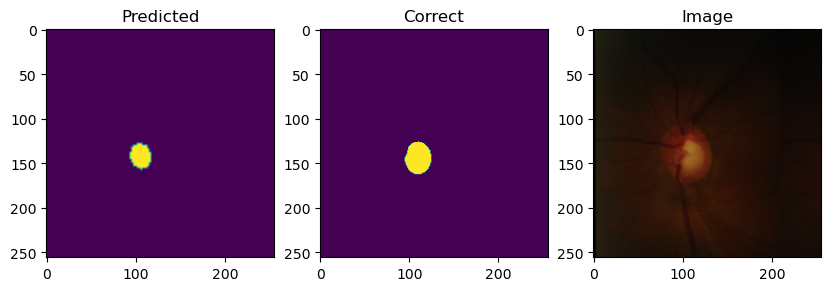

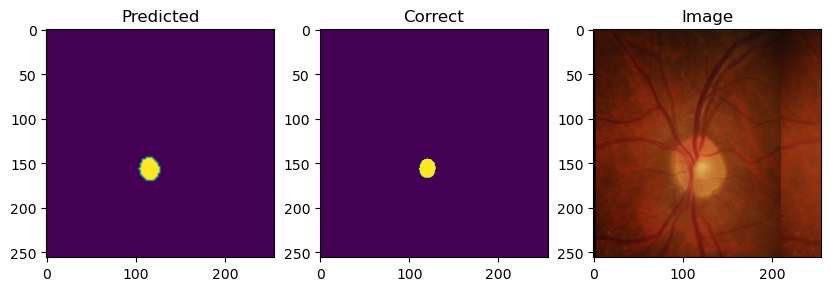

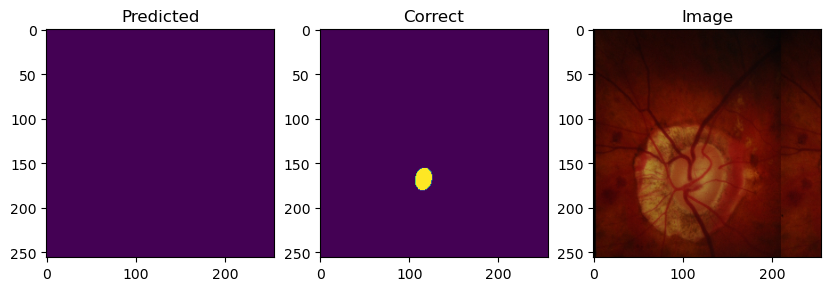

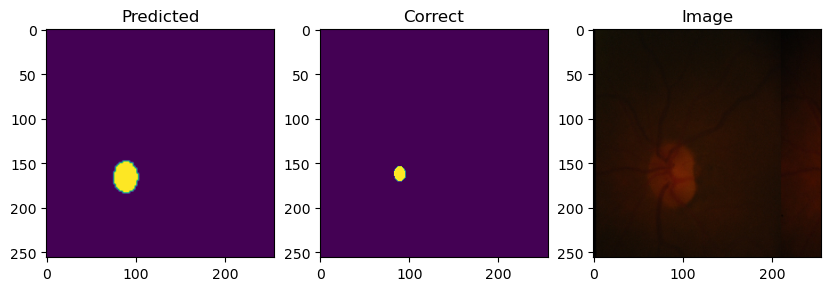

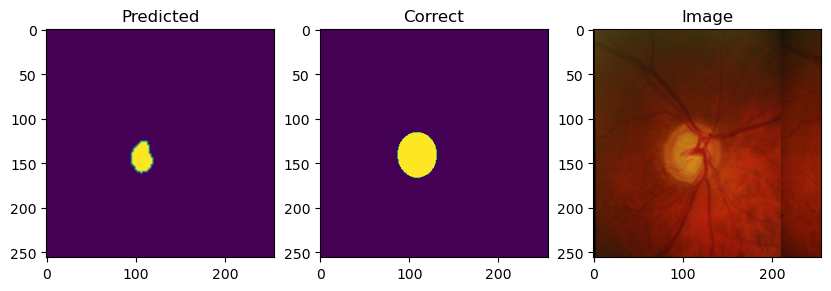

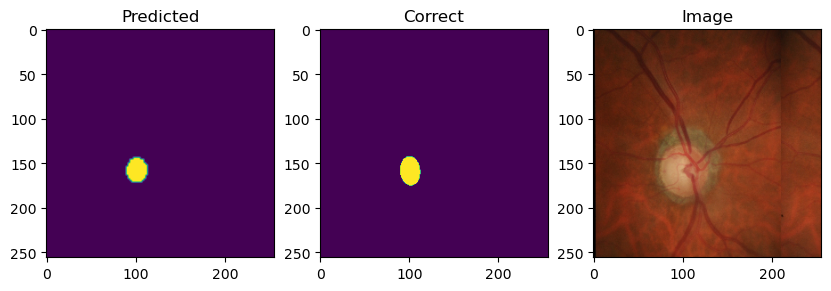

In [13]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
#     edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
#     edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(pred)


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
#     edgesc = canny(mask)
#     edgesc = 1.0-dilation(edgesc)
#     edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(mask)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])